<a href="https://colab.research.google.com/github/andy-wqfang/EE488_IBED/blob/main/EE488_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Environment Settings

In [ ]:
# All Includes

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Conv1D
from tensorflow.keras.utils import to_categorical
import os

In [ ]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "acc.x",
    "acc.y",
    "acc.z",
    "gyro.x",
    "gyro.y",
    "gyro.z",
]

# #LABELS WITH SHOT
LABELS = [
    "FULL_STRIKE",
    "LIFT",
    "CHOP",
    "BACKHAND_SAVE",
]
#LABELS WITHOUT SHOT
LABELS_WT = [
    "FULL_STRIKE_CLEAN",
    "LIFT_CLEAN",
    "CHOP_CLEAN",
    "BACKHAND_SAVE_CLEAN",

]




## Data processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
from collections import defaultdict


In [ ]:
def read_all_files_in_directory(directory_path,label,dataset,labels):
    all_data_blocks = {}
    lens = []
    for filename in os.listdir(directory_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory_path, filename)
            pattern = r'(.*?)\.csv'
            # 使用正则表达式进行匹配
            data_blocks = read_csv_blocks(file_path)
            matchs = re.search(pattern, filename)
            dataset[matchs.group(1).upper()].extend(data_blocks)  # 将当前文件的所有数据块添加到总列表中
            labels[matchs.group(1).upper()].extend([label for x in range(0,len(data_blocks))])
    return lens

In [ ]:

def read_csv_blocks(file_path):

    with open(file_path, 'r') as file:
        lines = file.readlines()

    data_blocks = []
    current_block = []

    for line in lines:
        if line.strip() == '':  # encounter blank line
            if current_block:
                data_blocks.append(current_block)
                current_block = []
        else:
            current_block.append(line.strip().split(','))  # 将行数据拆分并加入当前块

    # 添加最后一个块（如果存在）
    if current_block:
        data_blocks.append(current_block)

    # set up dataframes
    dataframes = []
    i=0
    for block in data_blocks:
        # 将每个块转换为DataFrame
        #df = pd.DataFrame(block[1:], columns=block[0])  # 跳过标题行
        if i  != 0:
          dataframes.append([b for a in block for b in a ])
        else:
          dataframes.append([b for a in block[1:] for b in a ])
        i+=1
    #dataframes is a list
    return dataframes

# 1 Split the dataset

## 1.1 With-shot data

### A Pre-process data

In [ ]:
dataset = defaultdict(list)
labels = defaultdict(list)

In [ ]:
DATA_PATH = ('/content/drive/MyDrive/EE488/')

l = 0
for label in LABELS:
  print("Loading pattern: "+ label)
  read_all_files_in_directory(DATA_PATH+label+'/',l,dataset,labels)
  l += 1


Loading pattern: FULL_STRIKE
Loading pattern: LIFT
Loading pattern: CHOP
Loading pattern: BACKHAND_SAVE


In [ ]:
print(dataset.keys())#
print(labels.keys())

dict_keys(['USER1', 'USER2', 'USER3', 'USER4', 'USER5', 'USER6'])
dict_keys(['USER1', 'USER2', 'USER3', 'USER4', 'USER5', 'USER6'])
6


One-hot labels

In [ ]:

for user in ['USER2', 'USER4', 'USER3', 'USER1', 'USER5','USER6']:
  labels[user] = [[1 if i == value else 0 for i in range(4)] for value in labels[user]]


### B Split data for leave-one-user-out models

In [ ]:
#Spilit to 5 leave-one-user-out models and one general model

XLeaveUser1 = []
[XLeaveUser1.extend(value) for key, value in dataset.items() if key not in ('USER1')]
XLeaveUser2 = []
[XLeaveUser2.extend(value) for key, value in dataset.items() if key not in ('USER2')]
XLeaveUser3 = []
[XLeaveUser3.extend(value) for key, value in dataset.items() if key not in ('USER3')]
XLeaveUser4 = []
[XLeaveUser4.extend(value) for key, value in dataset.items() if key not in ('USER4')]
XLeaveUser5 = []
[XLeaveUser5.extend(value) for key, value in dataset.items() if key not in ('USER5')]
XLeaveUser6 = []
[XLeaveUser6.extend(value) for key, value in dataset.items() if key not in ('USER6')]


XGeneral =  []
[XGeneral.extend(value) for key, value in dataset.items()]
YLeaveUser1 = []
[YLeaveUser1.extend(value) for key, value in labels.items() if key not in ('USER1')]
YLeaveUser2 = []
[YLeaveUser2.extend(value) for key, value in labels.items() if key not in ('USER2')]
YLeaveUser3 = []
[YLeaveUser3.extend(value) for key, value in labels.items() if key not in ('USER3')]
YLeaveUser4 = []
[YLeaveUser4.extend(value) for key, value in labels.items() if key not in ('USER4')]
YLeaveUser5 = []
[YLeaveUser5.extend(value) for key, value in labels.items() if key not in ('USER5')]
YLeaveUser6 = []
[YLeaveUser6.extend(value) for key, value in labels.items() if key not in ('USER6')]


YGeneral =  []
[YGeneral.extend(value) for key, value in labels.items()]



[None, None, None, None, None, None]

In [ ]:
print(len(XLeaveUser1))
print(len(XLeaveUser2))
print(len(XLeaveUser3))
print(len(XLeaveUser4))
print(len(XLeaveUser5))
print(len(XLeaveUser6))
print(len(XGeneral))

print(len(YLeaveUser1))
print(len(YLeaveUser2))
print(len(YLeaveUser3))
print(len(YLeaveUser4))
print(len(YLeaveUser5))
print(len(YGeneral))

868
914
839
869
946
929
1073
868
914
839
869
946
1073


### C Split Train and Test set function

In [ ]:
import random
# set the seed
random.seed(42)
TRAIN_PERCENT = 80
TEST_PERCENT = 100 - TRAIN_PERCENT


In [ ]:
def split_train_test(x,y,mname):
  #x dataset,y dataset,model name
  train_size = int(len(x) * float(TRAIN_PERCENT/100))
  test_size = len(x) - train_size
  train_indices = random.sample(range(len(x)), train_size)

  x_train = []
  y_train = []
  for i in train_indices:
    x_train.append(x[i])
    y_train.append(y[i])
  x_test = []
  y_test = []

  for i in list(set(list(range(0, len(x))))-set(train_indices)):
    x_test.append(x[i])
    y_test.append(y[i])
  print(mname+" Train size: " + str(len(x_train)) +" Test size: " + str(len(x_test)))

  fx_train = [[float(item) for item in sublist] for sublist in x_train]
  fx_test = [[float(item) for item in sublist] for sublist in x_test]
  x_train_ = np.array(fx_train)
  y_train_ = np.array(y_train)
  print(f"Data type of x_train: {x_train_.dtype}")
  print(f"Data type of y_train: {y_train_.dtype}")
  x_test_ = np.array(fx_test)
  y_test_ = np.array(y_test)

  print(f"x_train shape: {x_train_.shape}")  #
  print(f"y_train shape: {y_train_.shape}")

  x_train__ = x_train_.reshape((x_train_.shape[0], 1, x_train_.shape[1]))
  x_test__ = x_test_.reshape((x_test_.shape[0], 1, x_test_.shape[1]))

  print(f"x_test shape: {x_test__.shape}")
  print(f"y_test shape: {y_test_.shape}")
  return x_train__,y_train_,x_test__,y_test_

In [ ]:
x_train_1,y_train_1,x_test_1,y_test_1 = split_train_test(XLeaveUser1,YLeaveUser1,"Leave User 1")
x_train_2,y_train_2,x_test_2,y_test_2 = split_train_test(XLeaveUser2,YLeaveUser2,"Leave User 2")
x_train_3,y_train_3,x_test_3,y_test_3 = split_train_test(XLeaveUser3,YLeaveUser3,"Leave User 3")
x_train_4,y_train_4,x_test_4,y_test_4 = split_train_test(XLeaveUser4,YLeaveUser4,"Leave User 4")
x_train_5,y_train_5,x_test_5,y_test_5 = split_train_test(XLeaveUser5,YLeaveUser5,"Leave User 5")
x_train_6,y_train_6,x_test_6,y_test_6 = split_train_test(XLeaveUser6,YLeaveUser6,"Leave User 6")

x_train_g,y_train_g,x_test_g,y_test_g = split_train_test(XGeneral,YGeneral,"General Model")

Leave User 1 Train size: 694 Test size: 174
Data type of x_train: float64
Data type of y_train: int64
x_train shape: (694, 120)
y_train shape: (694, 4)
x_test shape: (174, 1, 120)
y_test shape: (174, 4)
Leave User 2 Train size: 731 Test size: 183
Data type of x_train: float64
Data type of y_train: int64
x_train shape: (731, 120)
y_train shape: (731, 4)
x_test shape: (183, 1, 120)
y_test shape: (183, 4)
Leave User 3 Train size: 671 Test size: 168
Data type of x_train: float64
Data type of y_train: int64
x_train shape: (671, 120)
y_train shape: (671, 4)
x_test shape: (168, 1, 120)
y_test shape: (168, 4)
Leave User 4 Train size: 695 Test size: 174
Data type of x_train: float64
Data type of y_train: int64
x_train shape: (695, 120)
y_train shape: (695, 4)
x_test shape: (174, 1, 120)
y_test shape: (174, 4)
Leave User 5 Train size: 756 Test size: 190
Data type of x_train: float64
Data type of y_train: int64
x_train shape: (756, 120)
y_train shape: (756, 4)
x_test shape: (190, 1, 120)
y_test s

## 1.2 Without-shot data

### A Pre-process data

In [ ]:
dataset_wt = defaultdict(list)
labels_wt = defaultdict(list)

In [ ]:
DATA_PATH = ('/content/drive/MyDrive/EE488/')

l = 0
for label in LABELS_WT:
  print("Loading pattern: "+ label)
  read_all_files_in_directory(DATA_PATH+label+'/',l,dataset_wt,labels_wt)
  l += 1


Loading pattern: FULL_STRIKE_CLEAN
Loading pattern: LIFT_CLEAN
Loading pattern: CHOP_CLEAN
Loading pattern: BACKHAND_SAVE_CLEAN


In [ ]:
print(dataset_wt.keys())#
print(labels_wt.keys())

dict_keys(['USER3', 'USER2', 'USER1', 'USER6'])
dict_keys(['USER3', 'USER2', 'USER1', 'USER6'])


In [ ]:

for user in ['USER1','USER2','USER3','USER6']:
  labels_wt[user] = [[1 if i == value else 0 for i in range(4)] for value in labels_wt[user]]


### B Split data for leave-one-user out models

In [ ]:
#Spilit to 5 leave-one-user-out models and one general model

XLeaveUser1_wt = []
[XLeaveUser1_wt.extend(value) for key, value in dataset_wt.items() if key not in ('USER1')]
XLeaveUser2_wt = []
[XLeaveUser2_wt.extend(value) for key, value in dataset_wt.items() if key not in ('USER2')]
XLeaveUser3_wt = []
[XLeaveUser3_wt.extend(value) for key, value in dataset_wt.items() if key not in ('USER3')]
XLeaveUser6_wt = []
[XLeaveUser6_wt.extend(value) for key, value in dataset_wt.items() if key not in ('USER6')]
XGeneral_wt =  []
[XGeneral_wt.extend(value) for key, value in dataset_wt.items()]

YLeaveUser1_wt = []
[YLeaveUser1_wt.extend(value) for key, value in labels_wt.items() if key not in ('USER1')]
YLeaveUser2_wt = []
[YLeaveUser2_wt.extend(value) for key, value in labels_wt.items() if key not in ('USER2')]
YLeaveUser3_wt = []
[YLeaveUser3_wt.extend(value) for key, value in labels_wt.items() if key not in ('USER3')]
YLeaveUser6_wt = []
[YLeaveUser6_wt.extend(value) for key, value in labels_wt.items() if key not in ('USER6')]
YGeneral_wt =  []
[YGeneral_wt.extend(value) for key, value in labels_wt.items()]


[None, None, None, None]

In [ ]:
print(len(YGeneral_wt))

520


### C Split Train and Test set function

In [ ]:
import random
# set the seed
random.seed(42)
TRAIN_PERCENT = 80
TEST_PERCENT = 100 - TRAIN_PERCENT


In [ ]:
def split_train_test(x,y,mname):
  #x dataset,y dataset,model name
  train_size = int(len(x) * float(TRAIN_PERCENT/100))
  test_size = len(x) - train_size
  train_indices = random.sample(range(len(x)), train_size)

  x_train = []
  y_train = []
  for i in train_indices:
    x_train.append(x[i])
    y_train.append(y[i])
  x_test = []
  y_test = []

  for i in list(set(list(range(0, len(x))))-set(train_indices)):
    x_test.append(x[i])
    y_test.append(y[i])
  print(mname+" Train size: " + str(len(x_train)) +" Test size: " + str(len(x_test)))

  fx_train = [[float(item) for item in sublist] for sublist in x_train]
  fx_test = [[float(item) for item in sublist] for sublist in x_test]
  x_train_ = np.array(fx_train)
  y_train_ = np.array(y_train)
  print(f"Data type of x_train: {x_train_.dtype}")
  print(f"Data type of y_train: {y_train_.dtype}")
  x_test_ = np.array(fx_test)
  y_test_ = np.array(y_test)

  print(f"x_train shape: {x_train_.shape}")  #
  print(f"y_train shape: {y_train_.shape}")

  x_train__ = x_train_.reshape((x_train_.shape[0], 1, x_train_.shape[1]))
  x_test__ = x_test_.reshape((x_test_.shape[0], 1, x_test_.shape[1]))

  print(f"x_test shape: {x_test__.shape}")
  print(f"y_test shape: {y_test_.shape}")
  return x_train__,y_train_,x_test__,y_test_

In [ ]:
x_train_1_wt,y_train_1_wt,x_test_1_wt,y_test_1_wt = split_train_test(XLeaveUser1_wt,YLeaveUser1,"Leave User 1 without shot")
x_train_2_wt,y_train_2_wt,x_test_2_wt,y_test_2_wt = split_train_test(XLeaveUser2_wt,YLeaveUser2,"Leave User 2 without shot")
x_train_3_wt,y_train_3_wt,x_test_3_wt,y_test_3_wt = split_train_test(XLeaveUser3_wt,YLeaveUser3,"Leave User 3 without shot")
x_train_6_wt,y_train_6_wt,x_test_6_wt,y_test_6_wt = split_train_test(XLeaveUser6_wt,YLeaveUser6_wt,"Leave User 6without shot")
x_train_g_wt,y_train_g_wt,x_test_g_wt,y_test_g_wt = split_train_test(XGeneral,YGeneral,"General Model without shot")

Leave User 1 without shot Train size: 304 Test size: 76
Data type of x_train: float64
Data type of y_train: int64
x_train shape: (304, 120)
y_train shape: (304, 4)
x_test shape: (76, 1, 120)
y_test shape: (76, 4)
Leave User 2 without shot Train size: 310 Test size: 78
Data type of x_train: float64
Data type of y_train: int64
x_train shape: (310, 120)
y_train shape: (310, 4)
x_test shape: (78, 1, 120)
y_test shape: (78, 4)
Leave User 3 without shot Train size: 313 Test size: 79
Data type of x_train: float64
Data type of y_train: int64
x_train shape: (313, 120)
y_train shape: (313, 4)
x_test shape: (79, 1, 120)
y_test shape: (79, 4)
Leave User 6without shot Train size: 320 Test size: 80
Data type of x_train: float64
Data type of y_train: int64
x_train shape: (320, 120)
y_train shape: (320, 4)
x_test shape: (80, 1, 120)
y_test shape: (80, 4)
General Model without shot Train size: 858 Test size: 215
Data type of x_train: float64
Data type of y_train: int64
x_train shape: (858, 120)
y_train

# 2 Model building and training

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.LSTM(120, return_sequences=True)(inputs)
    x = layers.Dropout(0.4)(x)

    x = layers.LSTM(120)(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(120, activation='relu')(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, x)

# Define input shape and number of classes
input_shape = (1, 120)
num_classes = 4
# Create the model



## With_shot_model training

In [ ]:
model_1 = make_model(input_shape, num_classes)
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model_2 = make_model(input_shape, num_classes)
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model_3 = make_model(input_shape, num_classes)
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_4 = make_model(input_shape, num_classes)
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_5 = make_model(input_shape, num_classes)
model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_6 = make_model(input_shape, num_classes)
model_6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_g = make_model(input_shape, num_classes)
model_g.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model_g.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1, 120)]          0         
                                                                 
 lstm_12 (LSTM)              (None, 1, 120)            115680    
                                                                 
 dropout_12 (Dropout)        (None, 1, 120)            0         
                                                                 
 lstm_13 (LSTM)              (None, 120)               115680    
                                                                 
 dropout_13 (Dropout)        (None, 120)               0         
                                                                 
 dense_12 (Dense)            (None, 120)               14520     
                                                                 
 dense_13 (Dense)            (None, 4)                 484 

Train

In [ ]:

EPOCHS = 50
# Callback to save model checkpoints for future inspection or training
loss = []
accuracy = []

#model_1
print(f'model_1 begins to train....')
history_1 = model_1.fit(x_train_1, y_train_1, epochs=EPOCHS,
          batch_size = 8,validation_data=(x_test_1, y_test_1))
lo, ac = model_1.evaluate(x_test_1, y_test_1)
loss.append(lo)
accuracy.append(ac)

#model_2

print(f'model_2) begins to train....')
history_2 = model_2.fit(x_train_2, y_train_2, epochs=EPOCHS,
          batch_size = 8,validation_data=(x_test_2, y_test_2))
lo, ac = model_2.evaluate(x_test_2, y_test_2)
loss.append(lo)
accuracy.append(ac)
#model_3

print(f'model_3 begins to train....')
history_3 = model_3.fit(x_train_3, y_train_3, epochs=EPOCHS,
          batch_size = 8,validation_data=(x_test_3, y_test_3))
lo, ac = model_3.evaluate(x_test_3, y_test_3)
loss.append(lo)
accuracy.append(ac)
#model_4

print(f'model_4 begins to train....')
history_4 = model_4.fit(x_train_4, y_train_4, epochs=EPOCHS,
          batch_size = 8,validation_data=(x_test_4, y_test_4))
lo, ac = model_4.evaluate(x_test_4, y_test_4)
loss.append(lo)
accuracy.append(ac)
#model_5
print(f'model_5 begins to train....')
history_5 = model_5.fit(x_train_5, y_train_5, epochs=EPOCHS,
          batch_size = 8,validation_data=(x_test_5, y_test_5))
lo, ac = model_5.evaluate(x_test_5, y_test_5)
loss.append(lo)
accuracy.append(ac)

#model_5
print(f'model_5 begins to train....')
history_6 = model_6.fit(x_train_6, y_train_6, epochs=EPOCHS,
          batch_size = 8,validation_data=(x_test_6, y_test_6))
lo, ac = model_6.evaluate(x_test_6, y_test_6)
loss.append(lo)
accuracy.append(ac)

#model_g
print(f'model_g begins to train....')
history_g = model_g.fit(x_train_g, y_train_g, epochs=EPOCHS,
          batch_size = 8,validation_data=(x_test_g, y_test_g))
lo, ac = model_g.evaluate(x_test_g, y_test_g)
loss.append(lo)
accuracy.append(ac)


model_1 begins to train....
Epoch 1/50
87/87 [==============================] - 8s 17ms/step - loss: 1.3278 - accuracy: 0.3429 - val_loss: 1.2041 - val_accuracy: 0.4080
Epoch 2/50
87/87 [==============================] - 1s 7ms/step - loss: 1.0607 - accuracy: 0.5159 - val_loss: 0.9967 - val_accuracy: 0.5460
Epoch 3/50
87/87 [==============================] - 1s 9ms/step - loss: 0.9084 - accuracy: 0.6095 - val_loss: 0.9487 - val_accuracy: 0.5690
Epoch 4/50
87/87 [==============================] - 1s 10ms/step - loss: 0.8170 - accuracy: 0.6643 - val_loss: 0.8963 - val_accuracy: 0.6379
Epoch 5/50
87/87 [==============================] - 1s 11ms/step - loss: 0.7697 - accuracy: 0.6787 - val_loss: 0.8677 - val_accuracy: 0.6092
Epoch 6/50
87/87 [==============================] - 1s 10ms/step - loss: 0.6817 - accuracy: 0.7190 - val_loss: 0.8209 - val_accuracy: 0.6552
Epoch 7/50
87/87 [==============================] - 1s 10ms/step - loss: 0.6216 - accuracy: 0.7666 - val_loss: 0.8123 - val_accu

## Without_shot_model training

In [ ]:
model_1_wt = make_model(input_shape, num_classes)
model_1_wt.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model_2_wt = make_model(input_shape, num_classes)
model_2_wt.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model_3_wt = make_model(input_shape, num_classes)
model_3_wt.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_6_wt = make_model(input_shape, num_classes)
model_6_wt.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_g_wt = make_model(input_shape, num_classes)
model_g_wt.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:

EPOCHS = 50
# Callback to save model checkpoints for future inspection or training
loss_wt = []
accuracy_wt = []

#model_1
print(f'model_1_wt begins to train....')
history_1_wt = model_1_wt.fit(x_train_1_wt, y_train_1_wt, epochs=EPOCHS,
          batch_size = 8,validation_data=(x_test_1_wt, y_test_1_wt))
lo, ac = model_1_wt.evaluate(x_test_1_wt, y_test_1_wt)
loss_wt.append(lo)
accuracy_wt.append(ac)

#model_2
print(f'model_2_wt begins to train....')
history_2_wt = model_2_wt.fit(x_train_2_wt, y_train_2_wt, epochs=EPOCHS,
          batch_size = 8,validation_data=(x_test_2_wt, y_test_2_wt))
lo, ac = model_2_wt.evaluate(x_test_2_wt, y_test_2_wt)
loss_wt.append(lo)
accuracy_wt.append(ac)

#model_3
print(f'model_3_wt begins to train....')
history_3_wt = model_3_wt.fit(x_train_3_wt, y_train_3_wt, epochs=EPOCHS,
          batch_size = 8,validation_data=(x_test_3_wt, y_test_3_wt))
lo, ac = model_3_wt.evaluate(x_test_3_wt, y_test_3_wt)
loss_wt.append(lo)
accuracy_wt.append(ac)

#model_6
print(f'model_6_wt begins to train....')
history_6_wt = model_6_wt.fit(x_train_6_wt, y_train_6_wt, epochs=EPOCHS,
          batch_size = 8,validation_data=(x_test_6_wt, y_test_6_wt))
lo, ac = model_6_wt.evaluate(x_test_6_wt, y_test_6_wt)
loss_wt.append(lo)
accuracy_wt.append(ac)


#model_g
print(f'model_g_wt begins to train....')
history_g_wt = model_g_wt.fit(x_train_g_wt, y_train_g_wt, epochs=EPOCHS,
          batch_size = 8,validation_data=(x_test_g_wt, y_test_g_wt))
lo, ac = model_g_wt.evaluate(x_test_g_wt, y_test_g_wt)
loss_wt.append(lo)
accuracy_wt.append(ac)


model_1_wt begins to train....
Epoch 1/50
38/38 [==============================] - 5s 31ms/step - loss: 1.3677 - accuracy: 0.3849 - val_loss: 1.3396 - val_accuracy: 0.3684
Epoch 2/50
38/38 [==============================] - 0s 6ms/step - loss: 1.2901 - accuracy: 0.3882 - val_loss: 1.2634 - val_accuracy: 0.3947
Epoch 3/50
38/38 [==============================] - 0s 6ms/step - loss: 1.1490 - accuracy: 0.4704 - val_loss: 1.1329 - val_accuracy: 0.5921
Epoch 4/50
38/38 [==============================] - 0s 7ms/step - loss: 0.9979 - accuracy: 0.6020 - val_loss: 1.0511 - val_accuracy: 0.5921
Epoch 5/50
38/38 [==============================] - 0s 7ms/step - loss: 0.8522 - accuracy: 0.6546 - val_loss: 1.0071 - val_accuracy: 0.5921
Epoch 6/50
38/38 [==============================] - 0s 7ms/step - loss: 0.7929 - accuracy: 0.6546 - val_loss: 0.9089 - val_accuracy: 0.6053
Epoch 7/50
38/38 [==============================] - 0s 7ms/step - loss: 0.7264 - accuracy: 0.6875 - val_loss: 0.8857 - val_accur

## Plots functions

### Epoch loss and validation loss

In [ ]:
def plot_training(history,name):
  train_loss = history.history['loss']
  train_accuracy = history.history['accuracy']
  val_loss = history.history['val_loss']
  val_accuracy = history.history['val_accuracy']
  epochs = range(1, len(train_loss) + 1)

  # 绘制图表
  plt.figure(figsize=(10, 5))

  # 绘制损失曲线
  plt.plot(epochs, train_loss, 'b--', label='Training Loss')
  plt.plot(epochs, val_loss, 'r--', label='Validation Loss')

  # 绘制准确率曲线
  plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
  plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')

  plt.title(name+' training and validation metrics')
  plt.xlabel('Epochs')
  plt.grid(True)
  plt.legend()
  plt.show()



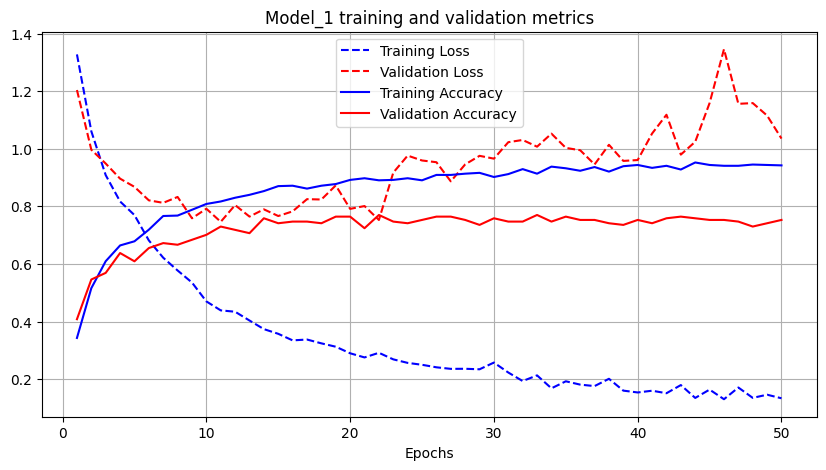

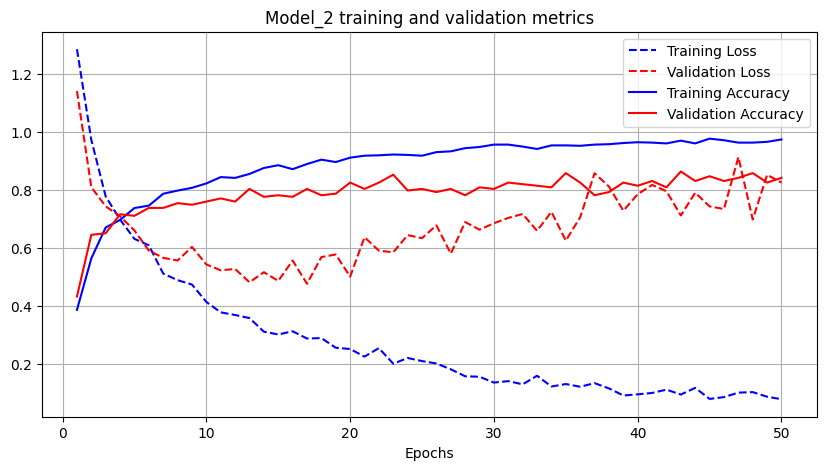

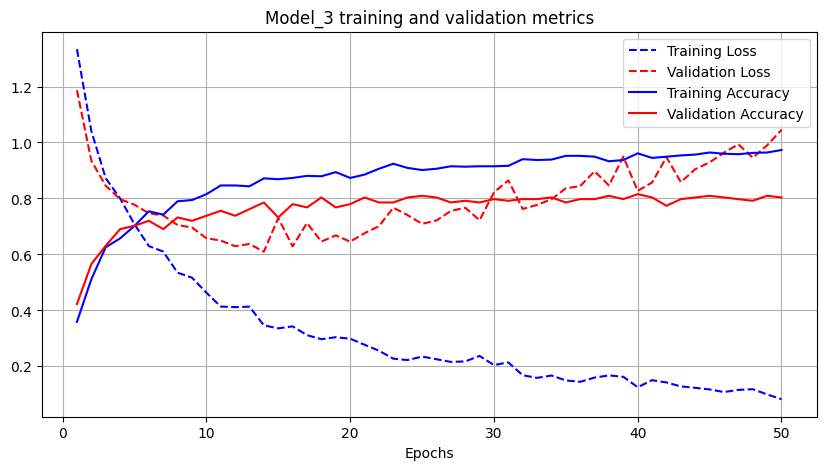

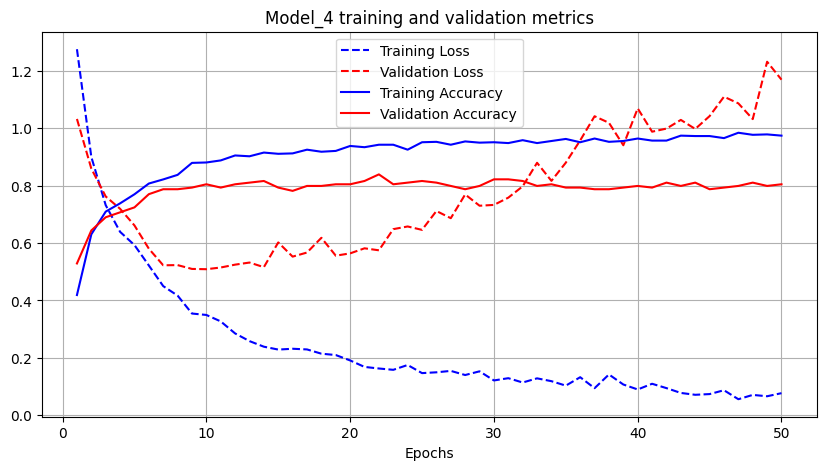

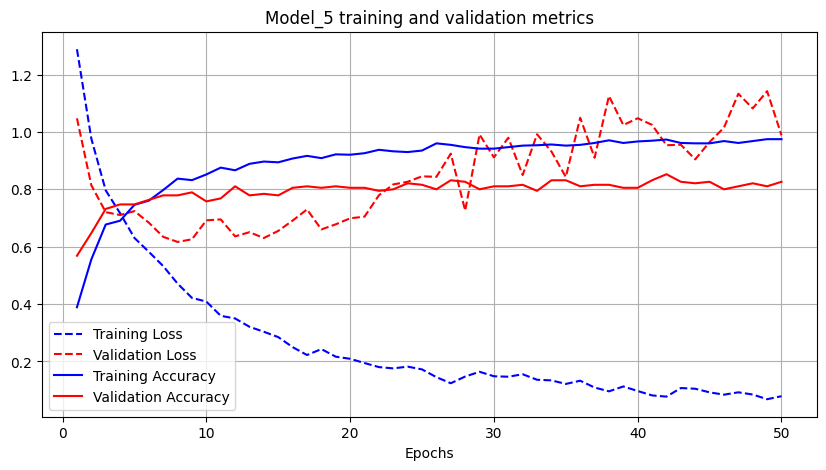

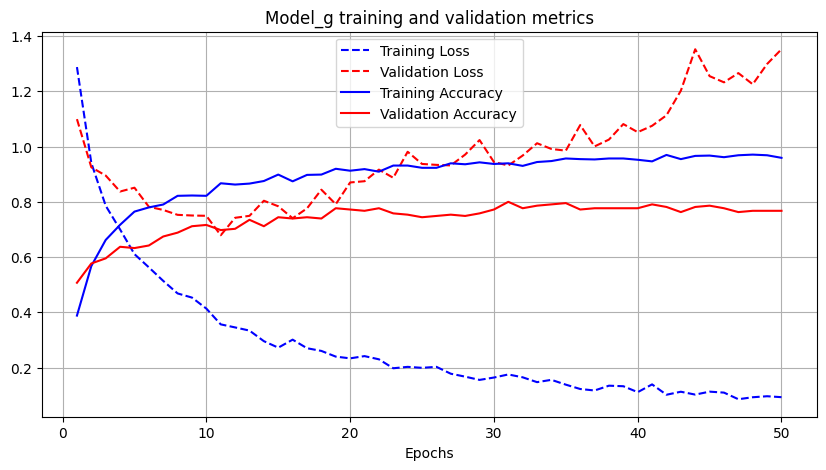

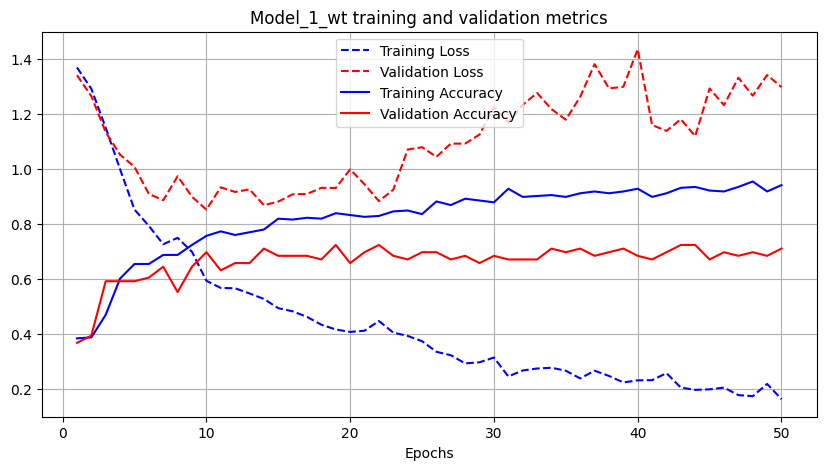

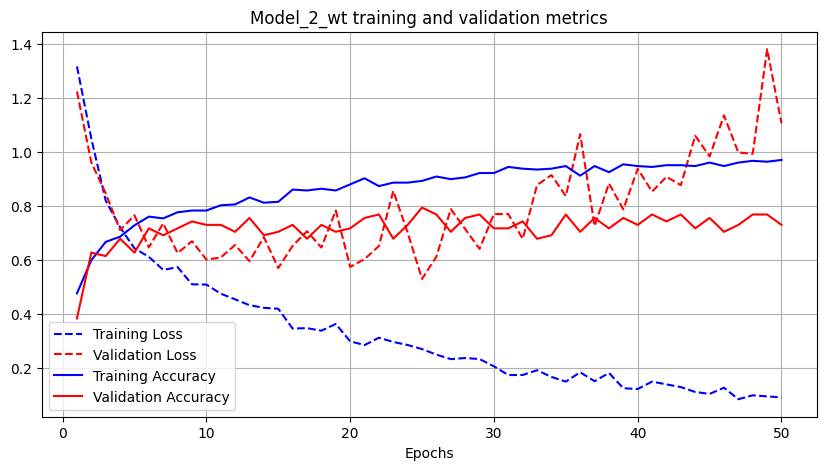

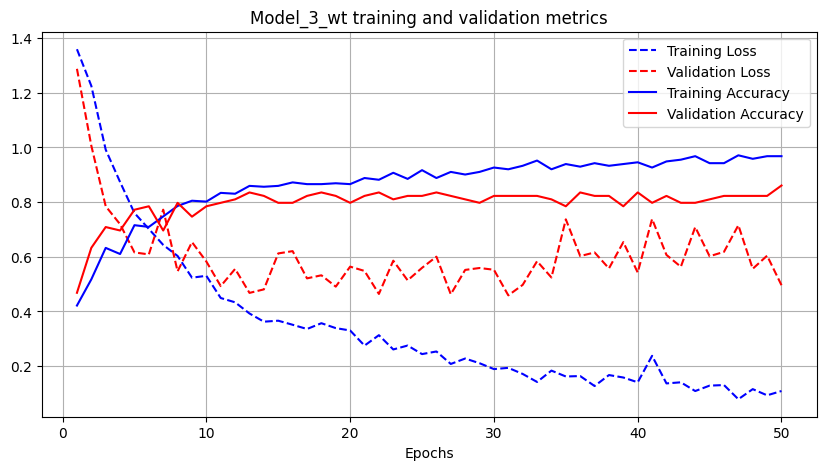

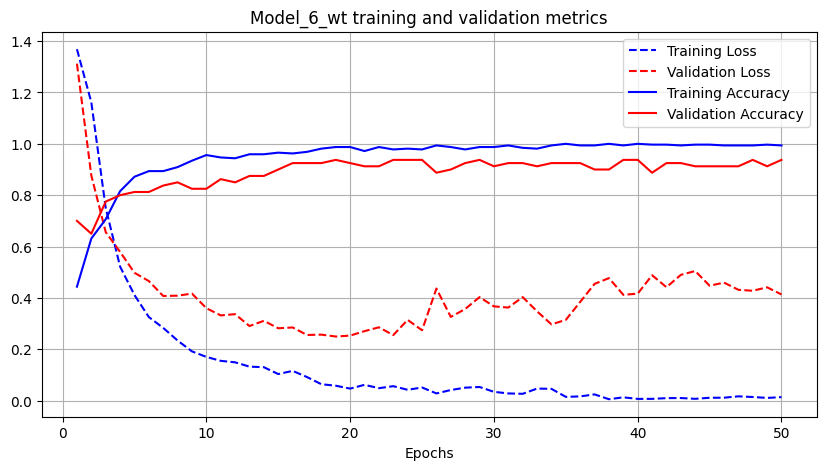

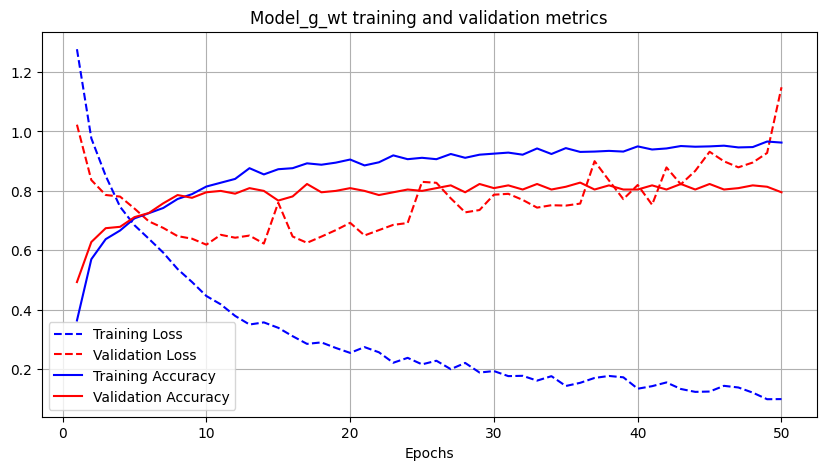

In [ ]:
plot_training(history_1,"Model_1")
plot_training(history_2,"Model_2")
plot_training(history_3,"Model_3")
plot_training(history_4,"Model_4")
plot_training(history_5,"Model_5")
plot_training(history_g,"Model_g")

plot_training(history_1_wt,"Model_1_wt")
plot_training(history_2_wt,"Model_2_wt")
plot_training(history_3_wt,"Model_3_wt")
plot_training(history_6_wt,"Model_6_wt")
plot_training(history_g_wt,"Model_g_wt")


### Plot test accuracy and loss

In [ ]:
import matplotlib.pyplot as plt

def plot_test(loss, accuracy, x):
    plt.figure(figsize=(10, 5))

    # 绘制准确率和损失曲线
    plt.plot(x, accuracy, 'r', marker='o', label='Test accuracy')
    plt.plot(x, loss, 'b', marker='o', label='Test loss')

    # 在每个点上添加数据标签
    for i in range(len(x)):
        plt.text(x[i], accuracy[i], f'{accuracy[i]:.2f}', ha='center', va='bottom', fontsize=9, color='red')
        plt.text(x[i], loss[i], f'{loss[i]:.2f}', ha='center', va='top', fontsize=9, color='blue')

    plt.title('Test set performance')
    plt.xlabel('Models')
    plt.grid(True)
    plt.legend()
    plt.show()

# 示例数据


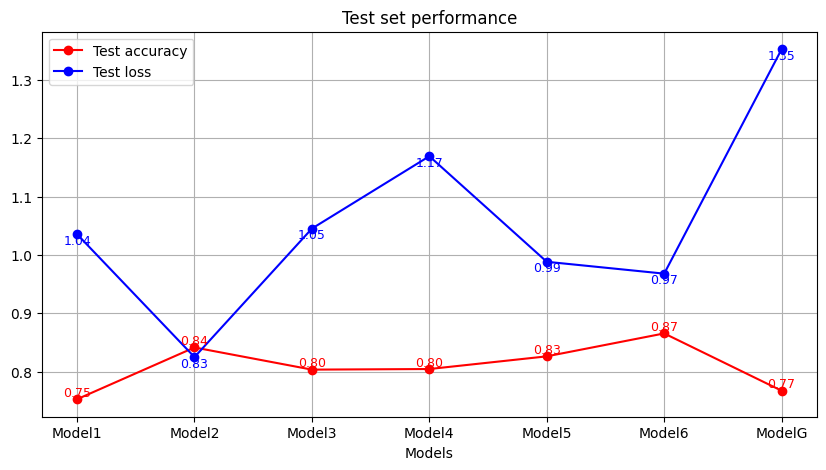

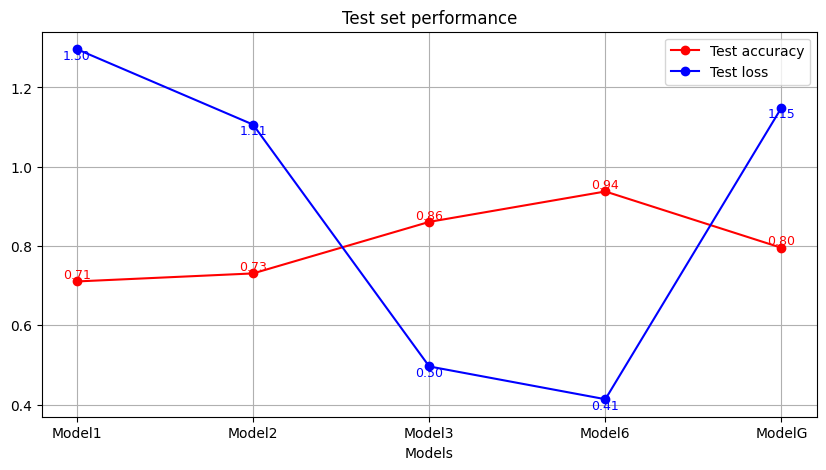

[1.0355030298233032, 0.8250529766082764, 1.0451760292053223, 1.1691268682479858, 0.9882994890213013, 0.9679762125015259, 1.3523892164230347]
[0.7528735399246216, 0.8415300250053406, 0.8035714030265808, 0.8045976758003235, 0.8263157606124878, 0.8655914068222046, 0.7674418687820435]
[1.2963637113571167, 1.106194257736206, 0.49612167477607727, 0.41340455412864685, 1.1489319801330566]
[0.7105262875556946, 0.7307692170143127, 0.8607594966888428, 0.9375, 0.7953488230705261]


In [ ]:
plot_test(loss,accuracy,['Model1','Model2','Model3','Model4','Model5','Model6','ModelG'])
plot_test(loss_wt,accuracy_wt,['Model1','Model2','Model3','Model6','ModelG'])
print(loss)
print(accuracy)
print(loss_wt)
print(accuracy_wt)

### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
def plot_cm(model,x_test_,y_test_):
# 获取模型在测试集上的预测结果
  y_pred = model.predict(x_test_)

  # 将预测结果转换为类别标签
  y_pred_classes = np.argmax(y_pred, axis=1)
  y_true_classes = np.argmax(y_test_, axis=1)

  # 计算混淆矩阵
  conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

  # 计算分类报告
  class_report = classification_report(y_true_classes, y_pred_classes)

  # 打印分类报告
  print("Classification Report:")
  print(class_report)

  # 绘制混淆矩阵
  plt.figure(figsize=(8, 6))
  plt.imshow(conf_matrix, cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.colorbar()
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.xticks(ticks=np.arange(len(conf_matrix)), labels=LABELS)
  plt.yticks(ticks=np.arange(len(conf_matrix)), labels=LABELS)
  plt.show()




6/6 [==============================] - 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88        62
           1       0.79      0.71      0.75        42
           2       0.62      0.80      0.70        35
           3       0.74      0.40      0.52        35

    accuracy                           0.75       174
   macro avg       0.74      0.72      0.71       174
weighted avg       0.76      0.75      0.74       174



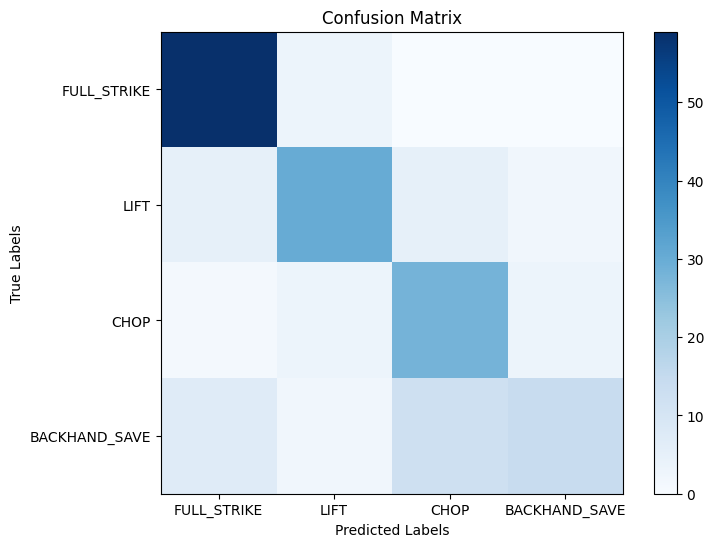

6/6 [==============================] - 0s 6ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91        56
           1       0.84      0.82      0.83        56
           2       0.78      0.85      0.81        33
           3       0.82      0.74      0.78        38

    accuracy                           0.84       183
   macro avg       0.83      0.83      0.83       183
weighted avg       0.84      0.84      0.84       183



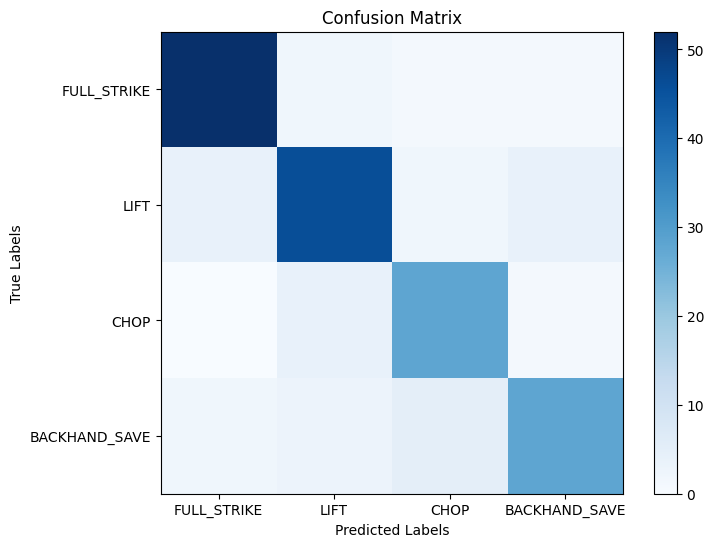

6/6 [==============================] - 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94        64
           1       0.69      0.78      0.74        32
           2       0.79      0.79      0.79        39
           3       0.70      0.48      0.57        33

    accuracy                           0.80       168
   macro avg       0.77      0.76      0.76       168
weighted avg       0.80      0.80      0.80       168



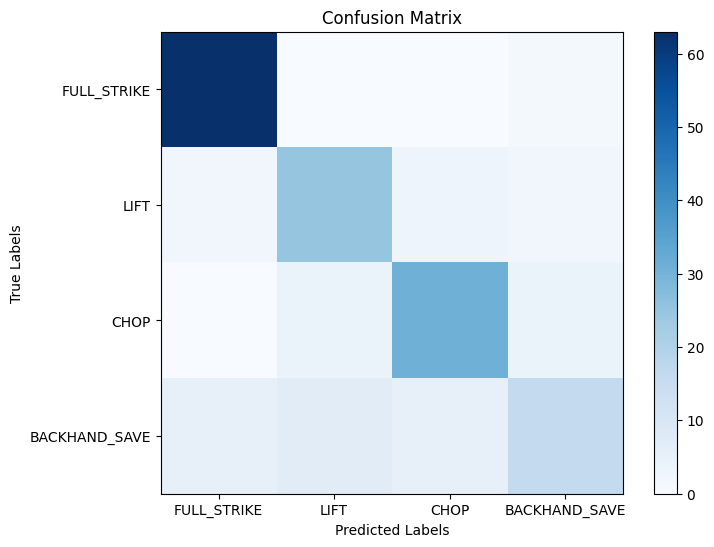

6/6 [==============================] - 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        75
           1       0.68      0.76      0.72        34
           2       0.68      0.81      0.74        32
           3       0.73      0.58      0.64        33

    accuracy                           0.80       174
   macro avg       0.76      0.77      0.76       174
weighted avg       0.81      0.80      0.80       174



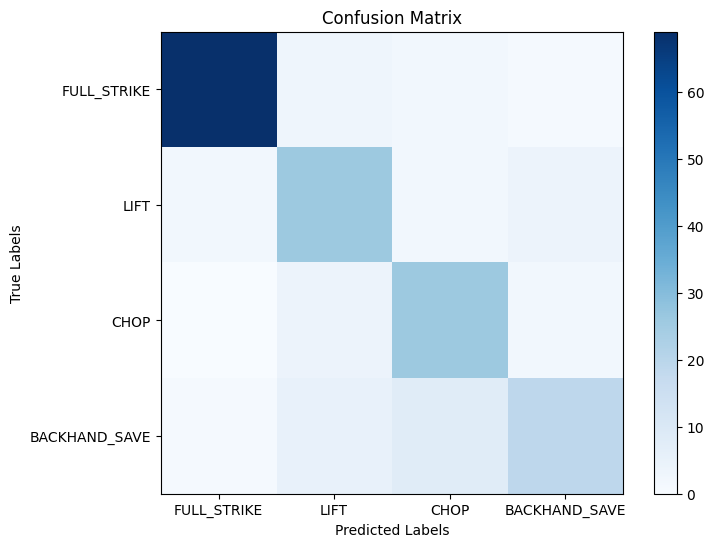

6/6 [==============================] - 0s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95        75
           1       0.79      0.88      0.83        51
           2       0.69      0.77      0.73        31
           3       0.73      0.48      0.58        33

    accuracy                           0.83       190
   macro avg       0.79      0.78      0.77       190
weighted avg       0.82      0.83      0.82       190



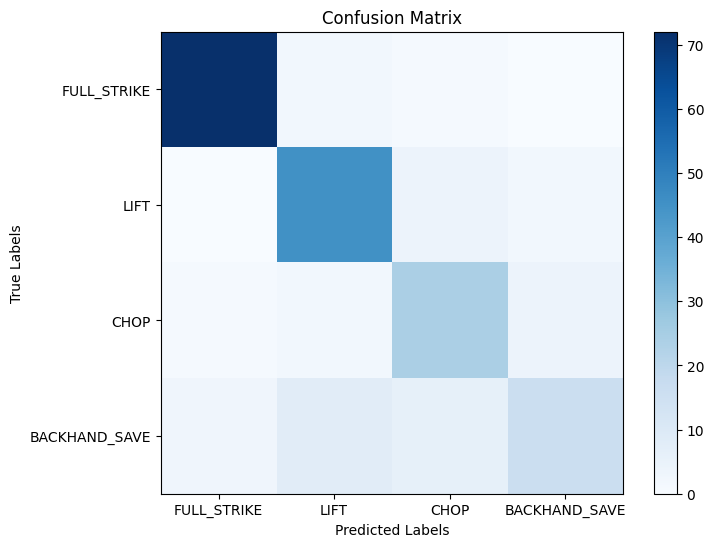

7/7 [==============================] - 0s 6ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        81
           1       0.78      0.62      0.69        50
           2       0.71      0.79      0.75        47
           3       0.57      0.57      0.57        37

    accuracy                           0.77       215
   macro avg       0.73      0.73      0.73       215
weighted avg       0.77      0.77      0.76       215



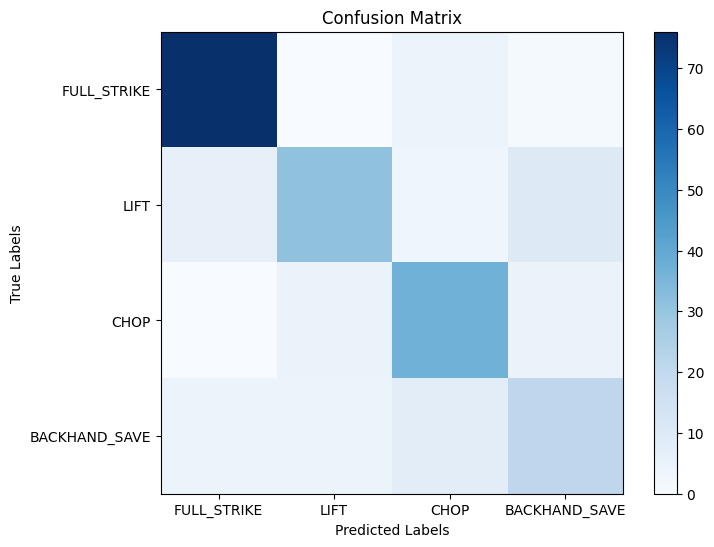

3/3 [==============================] - 0s 7ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.86      0.77        28
           1       0.69      0.56      0.62        16
           2       0.67      0.75      0.71        16
           3       0.82      0.56      0.67        16

    accuracy                           0.71        76
   macro avg       0.72      0.68      0.69        76
weighted avg       0.72      0.71      0.70        76



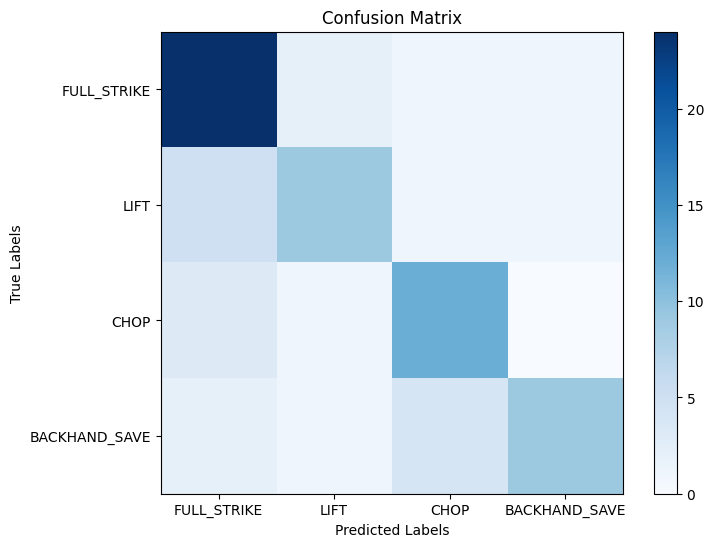

3/3 [==============================] - 0s 9ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.96      0.86        26
           1       0.67      0.72      0.69        25
           2       0.80      0.42      0.55        19
           3       0.67      0.75      0.71         8

    accuracy                           0.73        78
   macro avg       0.73      0.71      0.70        78
weighted avg       0.74      0.73      0.72        78



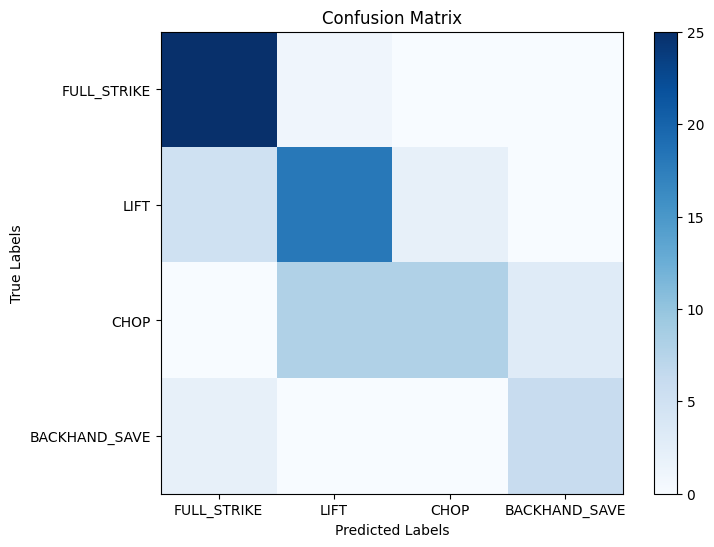

3/3 [==============================] - 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90        37
           1       0.82      0.64      0.72        14
           2       1.00      0.89      0.94        18
           3       0.73      0.80      0.76        10

    accuracy                           0.86        79
   macro avg       0.85      0.82      0.83        79
weighted avg       0.86      0.86      0.86        79



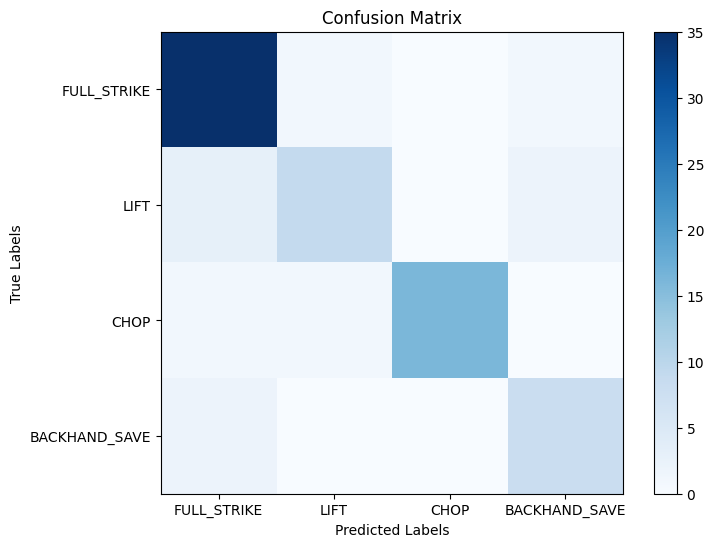

3/3 [==============================] - 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        21
           1       1.00      1.00      1.00        22
           2       0.75      0.92      0.83        13
           3       0.96      0.92      0.94        24

    accuracy                           0.94        80
   macro avg       0.93      0.94      0.93        80
weighted avg       0.95      0.94      0.94        80



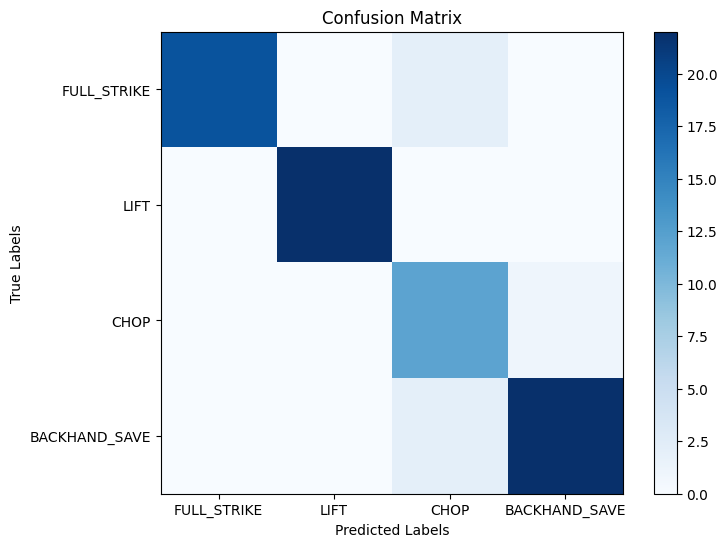

7/7 [==============================] - 4s 8ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.49      0.49        79
           1       0.46      0.51      0.48        47
           2       0.27      0.28      0.28        46
           3       0.31      0.26      0.28        43

    accuracy                           0.40       215
   macro avg       0.38      0.39      0.38       215
weighted avg       0.40      0.40      0.40       215



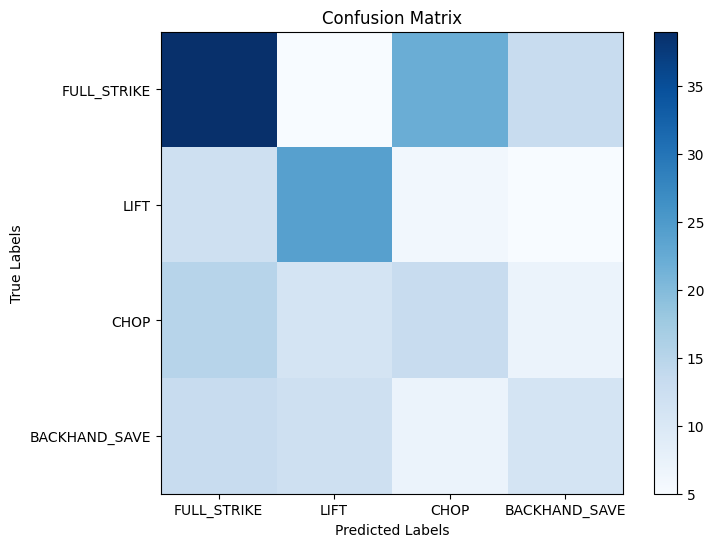

In [ ]:
plot_cm(model_1,x_test_1,y_test_1)
plot_cm(model_2,x_test_2,y_test_2)
plot_cm(model_3,x_test_3,y_test_3)
plot_cm(model_4,x_test_4,y_test_4)
plot_cm(model_5,x_test_5,y_test_5)
plot_cm(model_g,x_test_g,y_test_g)


plot_cm(model_1_wt,x_test_1_wt,y_test_1_wt)
plot_cm(model_2_wt,x_test_2_wt,y_test_2_wt)
plot_cm(model_3_wt,x_test_3_wt,y_test_3_wt)
plot_cm(model_6_wt,x_test_6_wt,y_test_6_wt)
plot_cm(model_g_wt,x_test_g,y_test_g_wt)

# Quantized model

In [ ]:
MODELS_DIR = os.path.join(DATA_PATH,"Models")
SAVED_MODEL_FILENAME = os.path.join(MODELS_DIR,"IBED")
FLOAT_TFL_MODEL_FILENAME = MODELS_DIR
print(FLOAT_TFL_MODEL_FILENAME)
QUANTIZED_TFL_MODEL_FILENAME = MODELS_DIR
# TFL_CC_MODEL_FILENAME = os.path.join(MODELS_DIR, "IBED.cc")
TFL_CC_MODEL_FILENAME = MODELS_DIR

/content/drive/MyDrive/EE488/Models


In [ ]:
#best performance and generalization
model_6.save(SAVED_MODEL_FILENAME+"_6")
model_g.save(SAVED_MODEL_FILENAME+"_g")


model_6_wt.save(SAVED_MODEL_FILENAME+"_6_wt")
model_g_wt.save(SAVED_MODEL_FILENAME+"_g_wt")


## No quantized model

In [ ]:

converter6 = tf.lite.TFLiteConverter.from_keras_model(model_6)
converterg = tf.lite.TFLiteConverter.from_keras_model(model_g)

converter6_wt = tf.lite.TFLiteConverter.from_keras_model(model_6_wt)
converterg_wt = tf.lite.TFLiteConverter.from_keras_model(model_g_wt)

In [ ]:
def no_quantized(converter,model,name):
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
  converter._experimental_lower_tensor_list_ops = False
  model_no_quant_tflite = converter.convert()
  PATH = os.path.join(FLOAT_TFL_MODEL_FILENAME,name)
  open(PATH, "wb").write(model_no_quant_tflite)


In [ ]:

no_quantized(converter6,model_6,"IBED_6.tfl")
no_quantized(converterg,model_g,"IBED_g.tfl")

no_quantized(converter6_wt,model_6_wt,"IBED_6_wt.tfl")
no_quantized(converterg_wt,model_g_wt,"IBED_g_wt.tfl")

## Quantized model

In [ ]:
def quantized(converter,model,name,datas):
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  # Enforce integer only quantization
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.SELECT_TF_OPS]
  converter.inference_input_type = tf.int8
  converter.inference_output_type = tf.int8
  def representative_dataset(datas):
    for test in datas:
      data = tf.expand_dims(test, 0)
      yield([data])
  # Provide a representative dataset to ensure we quantize correctly.
  converter.representative_dataset = lambda: representative_dataset(datas)
  model_tflite = converter.convert()
  # Save the model to dis
  PATH = os.path.join(QUANTIZED_TFL_MODEL_FILENAME,name)
  open(PATH, "wb").write(model_tflite)

In [ ]:

quantized(converter6,model_6,"IBED_q6.tfl",x_test_6.astype(np.float32))
quantized(converterg,model_g,"IBED_qg.tfl",x_test_g.astype(np.float32))

quantized(converter6_wt,model_6_wt,"IBED_q6.tfl",x_test_6_wt.astype(np.float32))
quantized(converterg_wt,model_g_wt,"IBED_qg.tfl",x_test_g_wt.astype(np.float32))

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
/usr/local/lib/python3.10/dist

##cc

In [ ]:
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {QUANTIZED_TFL_MODEL_FILENAME+"/IBED_q6.tfl"} > {TFL_CC_MODEL_FILENAME+'/IBED_q6.cc'}
!xxd -i {QUANTIZED_TFL_MODEL_FILENAME+"/IBED_qg.tfl"} > {TFL_CC_MODEL_FILENAME+'/IBED_qg.cc'}
!xxd -i {QUANTIZED_TFL_MODEL_FILENAME+"/IBED_q6_wt.tfl"} > {TFL_CC_MODEL_FILENAME+'/IBED_q6_wt.cc'}
!xxd -i {QUANTIZED_TFL_MODEL_FILENAME+"/IBED_qg_wt.tfl"} > {TFL_CC_MODEL_FILENAME+'/IBED_qg_wt.cc'}